# Titanic
[Comptetition 페이지 링크](https://www.kaggle.com/c/titanic/data?select=test.csv) <br>

## 진행 프로세스
1. 데이터셋 확인 <br>
    대부분의 캐글 데이터들은 잘 정제되어 있지만, 가끔 결측치가 존재 -> 이를 확인하고 향후 수정한다.
2. EDA <br>
    여러 feature들을 개별적으로 분석하고, feature들 간의 상관관계 확인 <br>
    여러 시각화 툴을 사용하여 insight를 얻음
3. feature engineering <br>
    모델을 세우기에 앞서 모델의 성능을 높일 수 있도록 feature들을 engineering함 <br>
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등
4. model 만들기 <br>
    `sklearn`을 사용하여 모델 만들기 - 수많은 알고리즘을 일관된 문법으로 사용할 수 있음<br>
    딥러닝을 위해 `tensorflow`, `pytorch` 등을 사용할 수 있음
5. 모델 학습 및 예측 <br>
    train set을 갖고 모델을 학습시킨 후 test set을 갖고 예측
6. 모델 평가 <br>
    예측 성능이 원하는 수준인지 판단 <br>
    풀려는 문제에 따라 모델을 평가하는 방식도 달라짐

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib의 기본 scheme 말고 seaborn의 scheme을 세팅하고
# 일일이 graph의 font size를 지정할 필요 없이 seaborn의 font_scale을 사용하면 편리하다.
plt.style.use("seaborn")
sns.set(font_scale=2.5) 

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import missingno as msno

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 1. 데이터셋 확인
- 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 `pandas`이다.
- `pandas`를 사용하여 데이터셋의 간단한 통계적 분석 부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있다.
- 캐글에서 데이터셋은 보통 train, testset 으로 나뉘어 있다.

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare이며, 예측하려는 target label은 Survived이다.
|변수(feature, variable)|정의|설명|타입|
|------|---|---|---|
|Survived|생존여부|target label. 1, 0으로 표현됨|integer|
|Pclass|티켓의 클래스|1=1st, 2=2nd, 3=3rd 클래스로 나뉘며, categorical feature|integer|
|Sex|성별|male, female로 구분되며 binary|string|
|Age|나이|continuous|integer|
|SibSp|함께 탑승한 형제와 배우자의 수|quantitative|integer|
|Parch|함께 탑승한 부모, 아이의 수|quantitative|integer|
|Ticket|티켓 번호|alphabet+integer|string|
|Fare|탑승료|continuous|float|
|Cabin|객실 번호|alphabet+integer|string|
|Embarked|탑승 항구|C=Cherbourg, Q=Queenstown, S=Southhampton|string|

- `pandas` `dataframe`에는 `describe()` 메소드가 있는데, 이를 쓰면 각 feature가 가진 통계치들을 반환해준다.

In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


- 테이블에서 보다시피 Passenger ID 수와 다른, 즉 결측치가 존재하는 feature가 있는 것 같다.
- 이를 좀 더 보기 편하도록 그래프로 시각화해서 살펴보자

## 1.1 Null Data Check

In [6]:
for col in df_train.columns:
    msg = f"column: {col:>10} Percent of NaN value: {100 * (df_train[col].isnull().sum() / df_train[col].shape[0]):.2f}%"
    print(msg)

column: PassengerId Percent of NaN value: 0.00%
column:   Survived Percent of NaN value: 0.00%
column:     Pclass Percent of NaN value: 0.00%
column:       Name Percent of NaN value: 0.00%
column:        Sex Percent of NaN value: 0.00%
column:        Age Percent of NaN value: 19.87%
column:      SibSp Percent of NaN value: 0.00%
column:      Parch Percent of NaN value: 0.00%
column:     Ticket Percent of NaN value: 0.00%
column:       Fare Percent of NaN value: 0.00%
column:      Cabin Percent of NaN value: 77.10%
column:   Embarked Percent of NaN value: 0.22%


In [7]:
for col in df_test.columns:
    msg = f"column: {col:>10} Percent of NaN value: {100 * (df_test[col].isnull().sum() / df_test[col].shape[0]):.2f}%"
    print(msg)

column: PassengerId Percent of NaN value: 0.00%
column:     Pclass Percent of NaN value: 0.00%
column:       Name Percent of NaN value: 0.00%
column:        Sex Percent of NaN value: 0.00%
column:        Age Percent of NaN value: 20.57%
column:      SibSp Percent of NaN value: 0.00%
column:      Parch Percent of NaN value: 0.00%
column:     Ticket Percent of NaN value: 0.00%
column:       Fare Percent of NaN value: 0.24%
column:      Cabin Percent of NaN value: 78.23%
column:   Embarked Percent of NaN value: 0.00%


- train, test set에서 Age(둘 다 약 20%), Cabin(둘 다 약 80%), Embarked(Train만 0.22%)의 결측치가 존재하는 것을 볼 수 있다.
- `missingno`라는 라이브러리를 사용하면 결측치의 존재를 더 쉽게 볼 수 있다.

<AxesSubplot:>

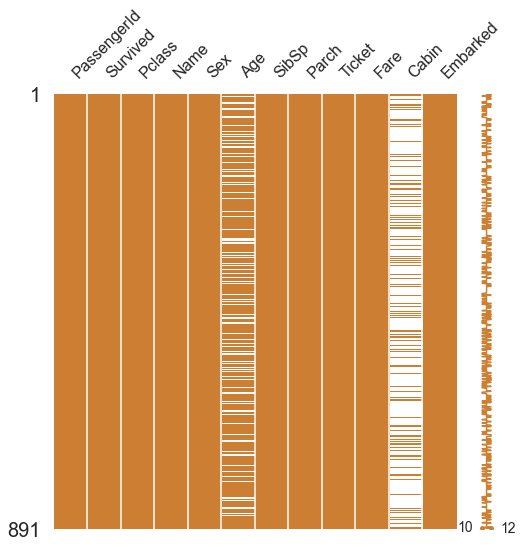

In [8]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<AxesSubplot:>

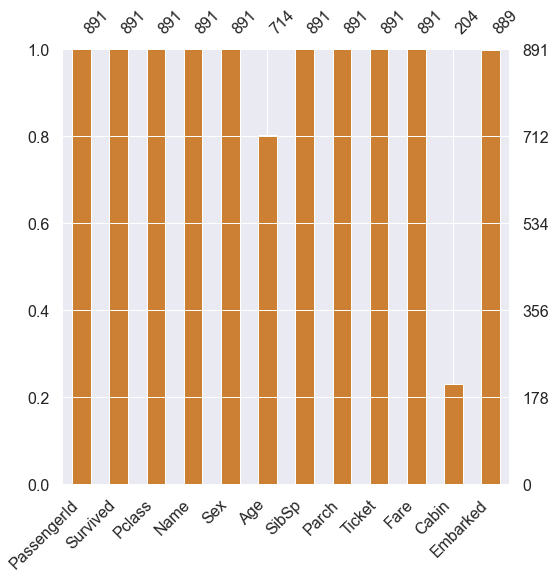

In [9]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<AxesSubplot:>

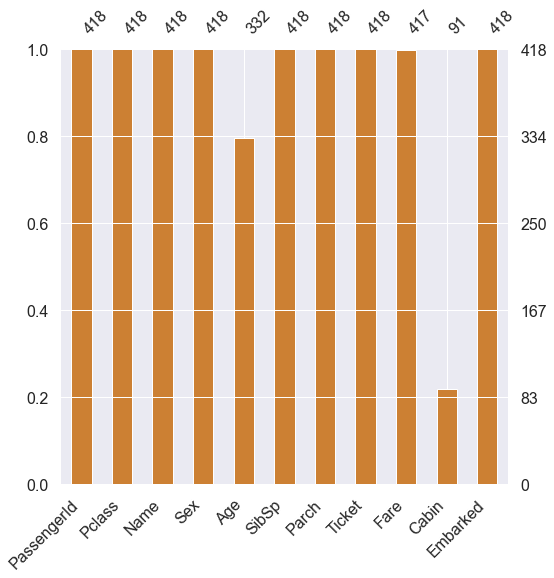

In [10]:
msno.bar(df=df_test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

## 1.2 Target Label 확인
- target label이 어떤 분포를 가지고 있는지 확인해봐야 함
- binary classification 문제의 경우, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있음

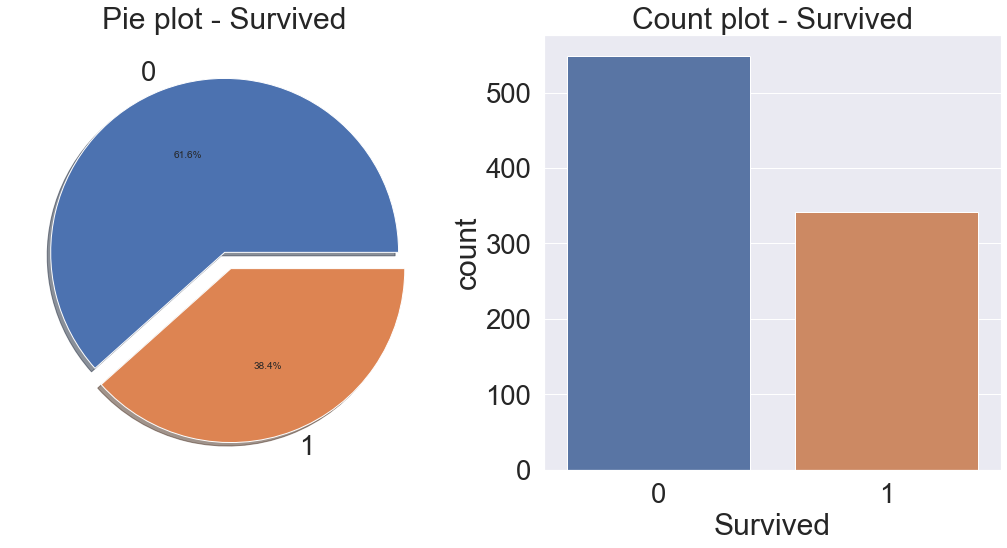

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train["Survived"].value_counts().plot.pie(explode=[0, 0.1], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Pie plot - Survived")
ax[0].set_ylabel("")
sns.countplot("Survived", data=df_train, ax=ax[1])
ax[1].set_title("Count plot - Survived")

plt.show()

- 사망자가 더 많다.
- 38.4% 가 생존
- target label의 분포가 제법 균일(balanced)하다. 불균일한 경우, 예를 들어 100 중 1이 99, 0이 1개인 경우, 모델이 모든 것을 1이라고 해도 정확도는 99%가 나오게 된다. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 된다.

# Exploratory Data Analysis (EDA)
- 본격적인 데이터 분석. 데이터는 매우 많다. 이 많은 데이터 안에 숨겨진 사실을 찾기 위해선 적절한 시각화가 필요하다.
- 시각화 라이브러리는 `matplotlib`, `seaborn`, `plotly` 등이 있다. 특정 목적에 맞는 소스코드를 정리해두어 필요할 때마다 참고하면 편하다.

## 2.1 Pclass
- 먼저 Pclass에 대해서 살펴보자. Pclass는 ordinal, 서수형 데이터이다. 카테고리이면서 순서가 있는 데이터 타입이다.
- 먼저 Pclass에 따른 생존율의 차이를 살펴보자. 엑셀의 피벗차트와 유사한 작업을 하게 되는데, `pandas` `DataFrame`에서는 `groupby`를 사용하면 쉽게 할 수 있다. 또한 `pivot`이라는 메소드도 있다.
- `Pclass`, `Survived`를 가져온 후, `Pclass`로 묶는다. 그러고 나면 각 `Pclass`마다 `0`. `1`이 count가 되는데, 이를 평균내면 각 `Pclass` 별 생존율이 나온다.
- 아래와 같이 `count()`를 하면 각 class에 몇 명이 있는지 확인할 수 있으며, `sum()`을 하면 216명 중 생존한(`Survived=1`) 사람의 총 합을 주게 된다.

In [12]:
df_train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [13]:
df_train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=True).sum()

,Survived
Pclass,
1,136
2,87
3,119


- `pandas`의 `crosstab`을 사용하면 좀 더 위 과정을 수월하게 볼 수 있다.

In [14]:
pd.crosstab(df_train["Pclass"], df_train["Survived"], margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


- grouped 객체에 `mean()`을 하게 되면 각 클래스 별 생존율을 얻을 수 있다. class 1이면 아래와 같다. <br>
$$\frac{80}{(80 + 136)}\approx 0.63$$

<AxesSubplot:xlabel='Pclass'>

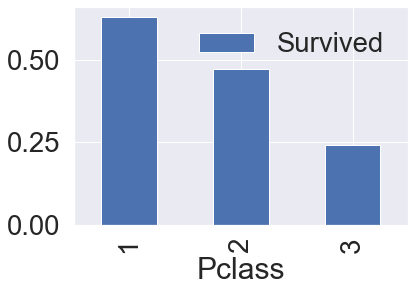

In [15]:
df_train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=True).mean().sort_values(by="Survived", ascending=False).plot.bar()

- 보다시피 Pclass가 좋을수록(1st) 생존율이 높은 것을 확인할 수 있다.
- 좀 더 보기 쉽게 그래프를 그려보자. `seaborn`의 `countplot`을 이용하면 특정 label에 따른 개수를 확인해볼 수 있다.

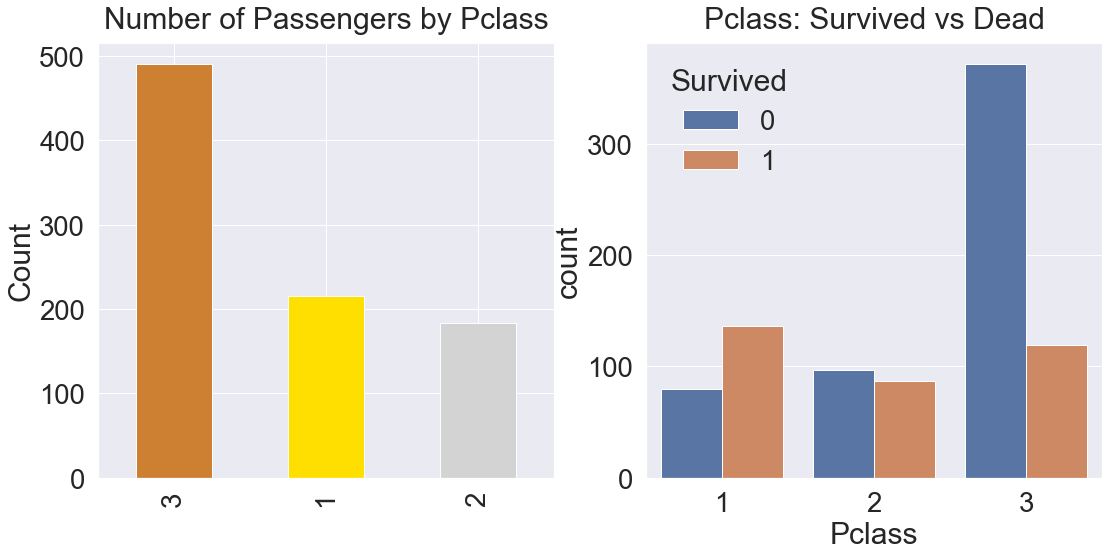

In [16]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train["Pclass"].value_counts().plot.bar(color=["#CD7F32", "#FFDF00", "#D3D3D3"], ax=ax[0])
ax[0].set_title("Number of Passengers by Pclass", y=y_position)
ax[0].set_ylabel("Count")

sns.countplot("Pclass", hue="Survived", data=df_train, ax=ax[1])
ax[1].set_title("Pclass: Survived vs Dead", y=y_position)

plt.show()

- 클래스가 높을 수록 생존 확률이 높은 것을 확인할 수 있다. Pclass 1, 2, 3 순서대로 `68%`, `48%`, `25%` 이다.
- 우리는 생존에 Pclass가 큰 영향을 미친다고 생각해 볼 수 있으며, 나중에 모델을 세울 때 이 feature를 사용하는 것이 좋을 것이라 판단할 수 있다.

## 2.2 Sex
- 이번에는 성별로 생존율이 어떻게 달라지는지 확인해보자
- 마찬가지로 `pandas`의 `groupby`와 `seaborn`의 `countplot`을 사용해서 시각화해본다

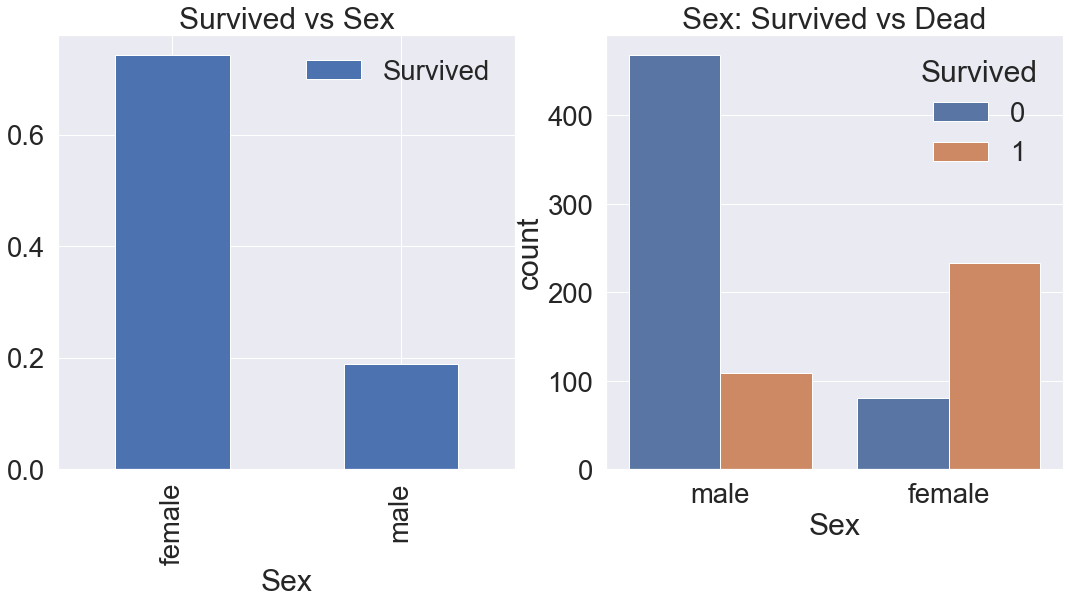

In [17]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train[["Sex", "Survived"]].groupby(["Sex"], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived vs Sex")

sns.countplot("Sex", hue="Survived", data=df_train, ax=ax[1])
ax[1].set_title("Sex: Survived vs Dead")

plt.show()

- 보다시피 여자가 생존할 확률이 높다.

In [18]:
df_train[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
pd.crosstab(df_train["Sex"], df_train["Survived"], margins=True).style.background_gradient(cmap="summer_r")

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


## 2.3 Both Sex and Pclass
- `Sex`, `Pclass` 두 가지 feature에 대하여 생존이 어떻게 달라지는지 확인해보자
- `seaborn`의 `factorplot`을 이용하면 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있다.

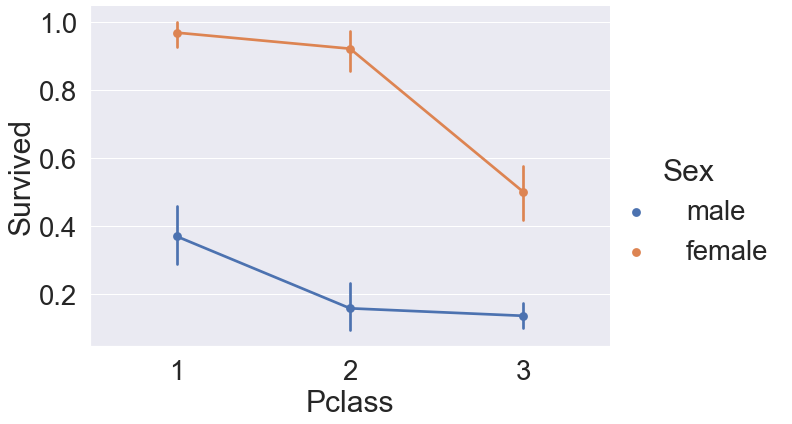

In [20]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=df_train, size=6, aspect=1.5)

- 모든 클래스에서 `female`의 생존 확률이 `male`보다 높다.
- 또한 남자, 여자 상관 없이 클래스가 높을수록 살 확률이 높다.
- 위 그래프를 `hue` 대신 `column`으로 하면 아래와 같아진다.

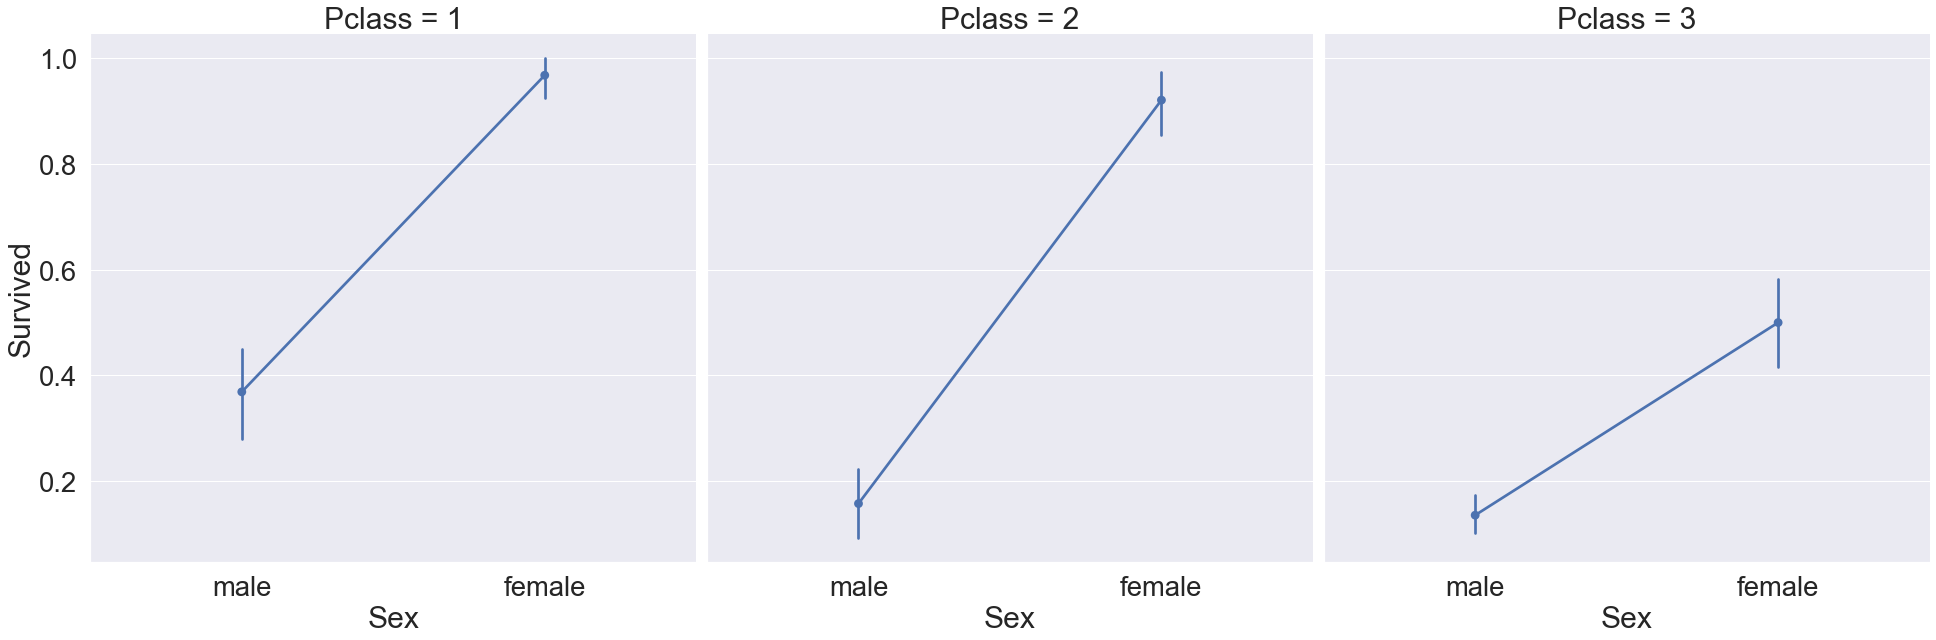

In [21]:
sns.factorplot(x="Sex", y="Survived", col="Pclass", data=df_train, saturation=.5, size=9, aspect=1)

## 2.4 Age
- Age feature를 살펴보자

In [22]:
print(f"제일 나이 많은 탑승객: {df_train['Age'].max():.1f} Years")
print(f"제일 어린 탑승객: {df_train['Age'].min():.1f} Years")
print(f"탑승객 평균 나이: {df_train['Age'].mean():.1f} Years")

제일 나이 많은 탑승객: 80.0 Years
제일 어린 탑승객: 0.4 Years
탑승객 평균 나이: 29.7 Years


- 생존에 따른 `Age`의 histogram을 그려보자

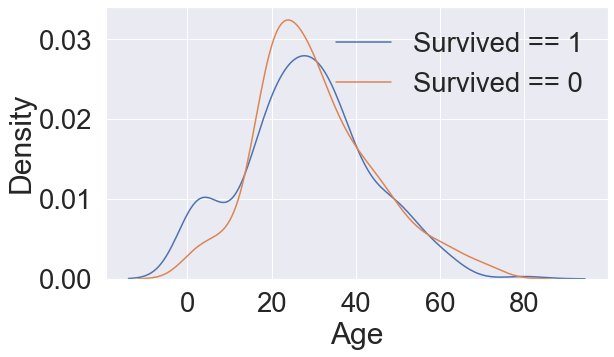

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

sns.kdeplot(df_train[df_train["Survived"] == 1]["Age"], ax=ax)
sns.kdeplot(df_train[df_train["Survived"] == 0]["Age"], ax=ax)

plt.legend(["Survived == 1", "Survived == 0"])
plt.show()

- 보다시피 생존자 중 나이가 어린 경우가 많음을 볼 수 있다.

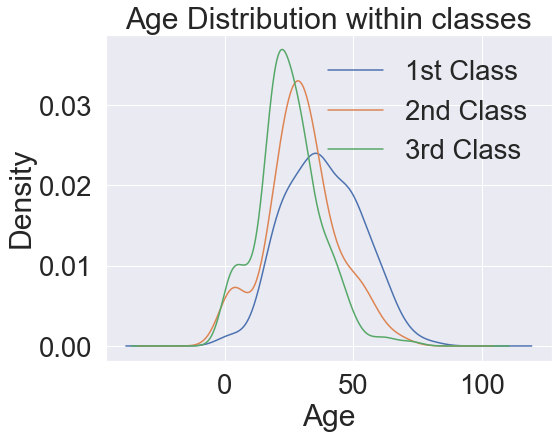

In [24]:
# Age distribution within classes

plt.figure(figsize=(8, 6))
df_train["Age"][df_train["Pclass"] == 1].plot(kind="kde")
df_train["Age"][df_train["Pclass"] == 2].plot(kind="kde")
df_train["Age"][df_train["Pclass"] == 3].plot(kind="kde")

plt.xlabel("Age")
plt.title("Age Distribution within classes")
plt.legend(["1st Class", "2nd Class", "3rd Class"])

- Class가 높을수록 나이 많은 사람의 비중이 커진다.
- 나이대가 변하면서 생존율이 어떻게 되는지 보려고 한다.
- 나이 범위를 점점 넓혀가며, 생존율이 어떻게 되는지 알아보자 

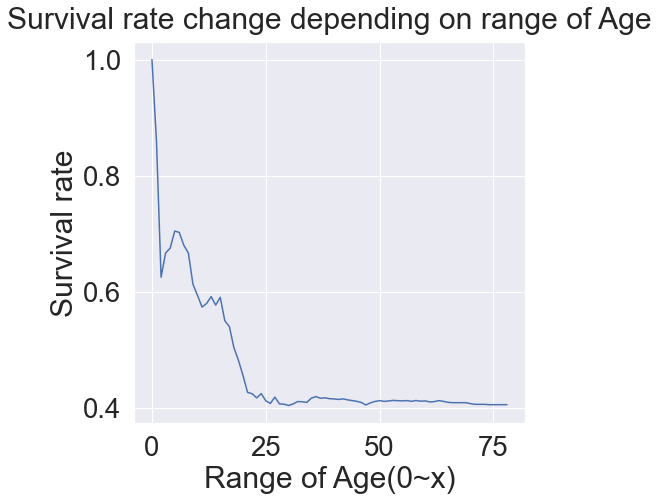

In [25]:
cummulate_survival_ratio = []
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train["Age"] < i]["Survived"].sum() / len(df_train[df_train["Age"] < i]["Survived"]))
    
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title("Survival rate change depending on range of Age", y=1.02)
plt.ylabel("Survival rate")
plt.xlabel("Range of Age(0~x)")
plt.show()

- 보다시피 나이가 어릴수록 생존율이 확실히 높은 것을 확인할 수 있다.
- 우리는 이 나이가 중요한 `feature`로 쓰일 수 있음을 확인했다.

## 2.5 Pclass, Sex, Age
- 지금까지 본 `Sex`, `Pclass`, `Age`, `Survived` 모두에 대해서 보고 싶다. 이를 쉽게 그려주는 것이 `seaborn`의 `violinplot`이다.
- `x`축은 우리가 나눠서 보고싶어하는 case (여기선 `Pclass`, `Sex`)를 나타내고, `y`축은 보고싶어하는 distribution(Age)이다.

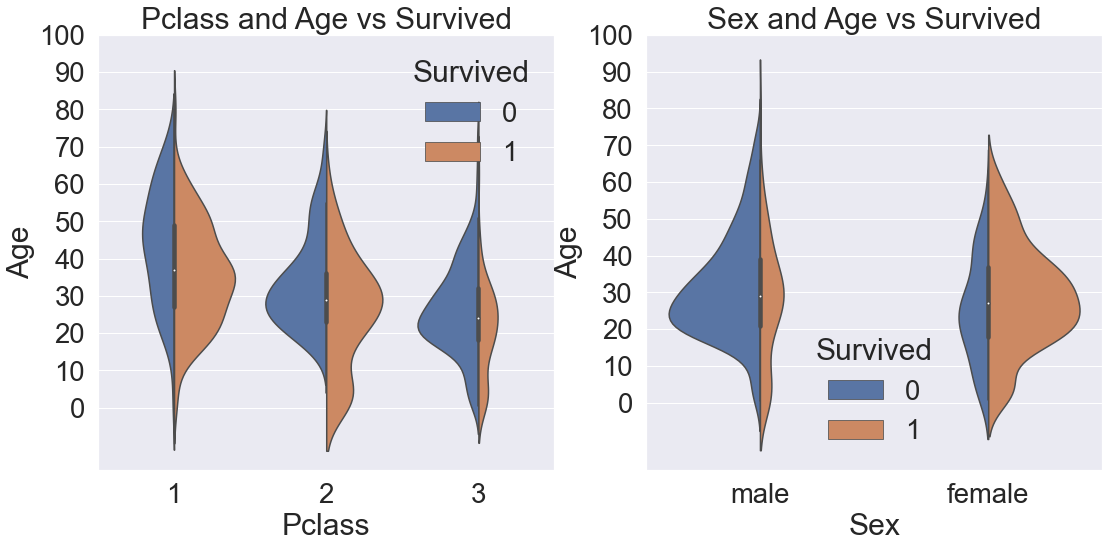

In [26]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=df_train, scale="count", split=True, ax=ax[0])
ax[0].set_title("Pclass and Age vs Survived")
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot("Sex", "Age", hue="Survived", data=df_train, scale="count", split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs Survived")
ax[1].set_yticks(range(0, 110, 10))

plt.show()

- 왼쪽 그림은 `Pclass` 별로 `Age`의 distribution이 어떻게 다른지, 거기에 생존 여부에 따라 구분한 그래프이다.
- 오른쪽 그림도 마찬가지로 `Sex`에 따른 `Age`의 distribution이 어떻게 다른지 보여주는 그래프이다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴수록 생존을 많이 한 것을 볼 수 있다.
- 오른쪽 그림에서 보면 명확히 여자가 생존을 많이 한 것을 볼 수 있다.
- 여성과 아이를 먼저 챙긴 것을 볼 수 있다.

## 2.6 Embarked
- `Embarked`는 탑승한 항구를 나타낸다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따른 생존율을 보자

<AxesSubplot:xlabel='Embarked'>

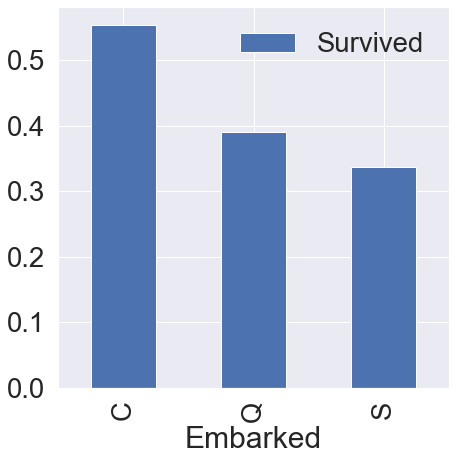

In [27]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[["Embarked", "Survived"]].groupby(["Embarked"], as_index=True).mean().sort_values(by="Survived", ascending=False).plot.bar(ax=ax)

- 보다시피 조금의 차이는 있지만 생존율은 좀 비슷한 것 같다. 그래도 `C`가 제일 높다.
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만 그래도 사용하자
- 사실 모델을 만들고 나면 우리가 사용한 `feature`들이 얼마나 중요한 역할을 했는지 확인해볼 수 있다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것이다.
- 다른 `feature`로 split하여 한 번 살펴보자

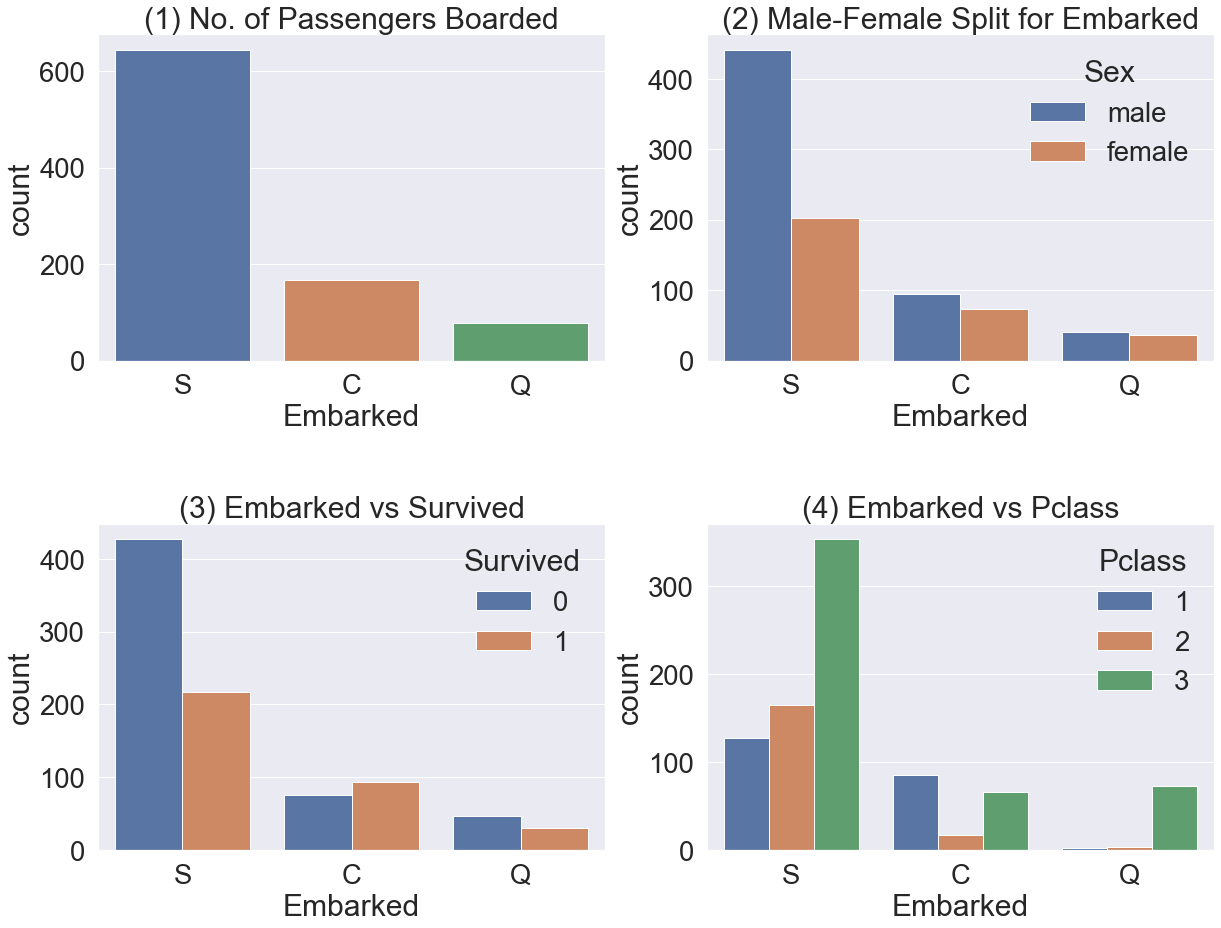

In [28]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot("Embarked", data=df_train, ax=ax[0, 0])
ax[0, 0].set_title("(1) No. of Passengers Boarded")
sns.countplot("Embarked", hue="Sex", data=df_train, ax=ax[0, 1])
ax[0, 1].set_title("(2) Male-Female Split for Embarked")
sns.countplot("Embarked", hue="Survived", data=df_train, ax=ax[1, 0])
ax[1, 0].set_title("(3) Embarked vs Survived")
sns.countplot("Embarked", hue="Pclass", data=df_train, ax=ax[1, 1])
ax[1, 1].set_title("(4) Embarked vs Pclass")
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) - 전체적으로 봤을 때, `S`에서 가장 많은 사람이 탑승했다.
- Figure(2) - `C`와 `Q`는 남녀 비율이 비슷하고, `S`는 남자가 더 많다.
- Figure(3) - 생존확률이 `S`의 경우 많이 낮은 걸 볼 수 있다. (이전 그래프에서 봤다.)
- Figure(4) - Class로 split해서 보니, `C`가 생존확률이 높은건 클래스가 높은 사람이 많이 타서 그렇다. `S`는 `3rd class`가 많아서 생존확률이 낮게 나온다.

## 2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)
- SibSp와 Parch를 합하면 Family가 될 것이다. 
- Family로 합쳐서 분석해보자

In [29]:
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1 # 자신을 포함해야하니 1을 더한다
df_test["FamilySize"] = df_test["SibSp"] + df_test["Parch"] + 1 # 자신을 포함해야하니 1을 더한다

In [30]:
print("Maximum size of Family: ", df_train["FamilySize"].max())
print("Minimum size of Family: ", df_train["FamilySize"].min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize와 생존의 관계를 한 번 살펴보자

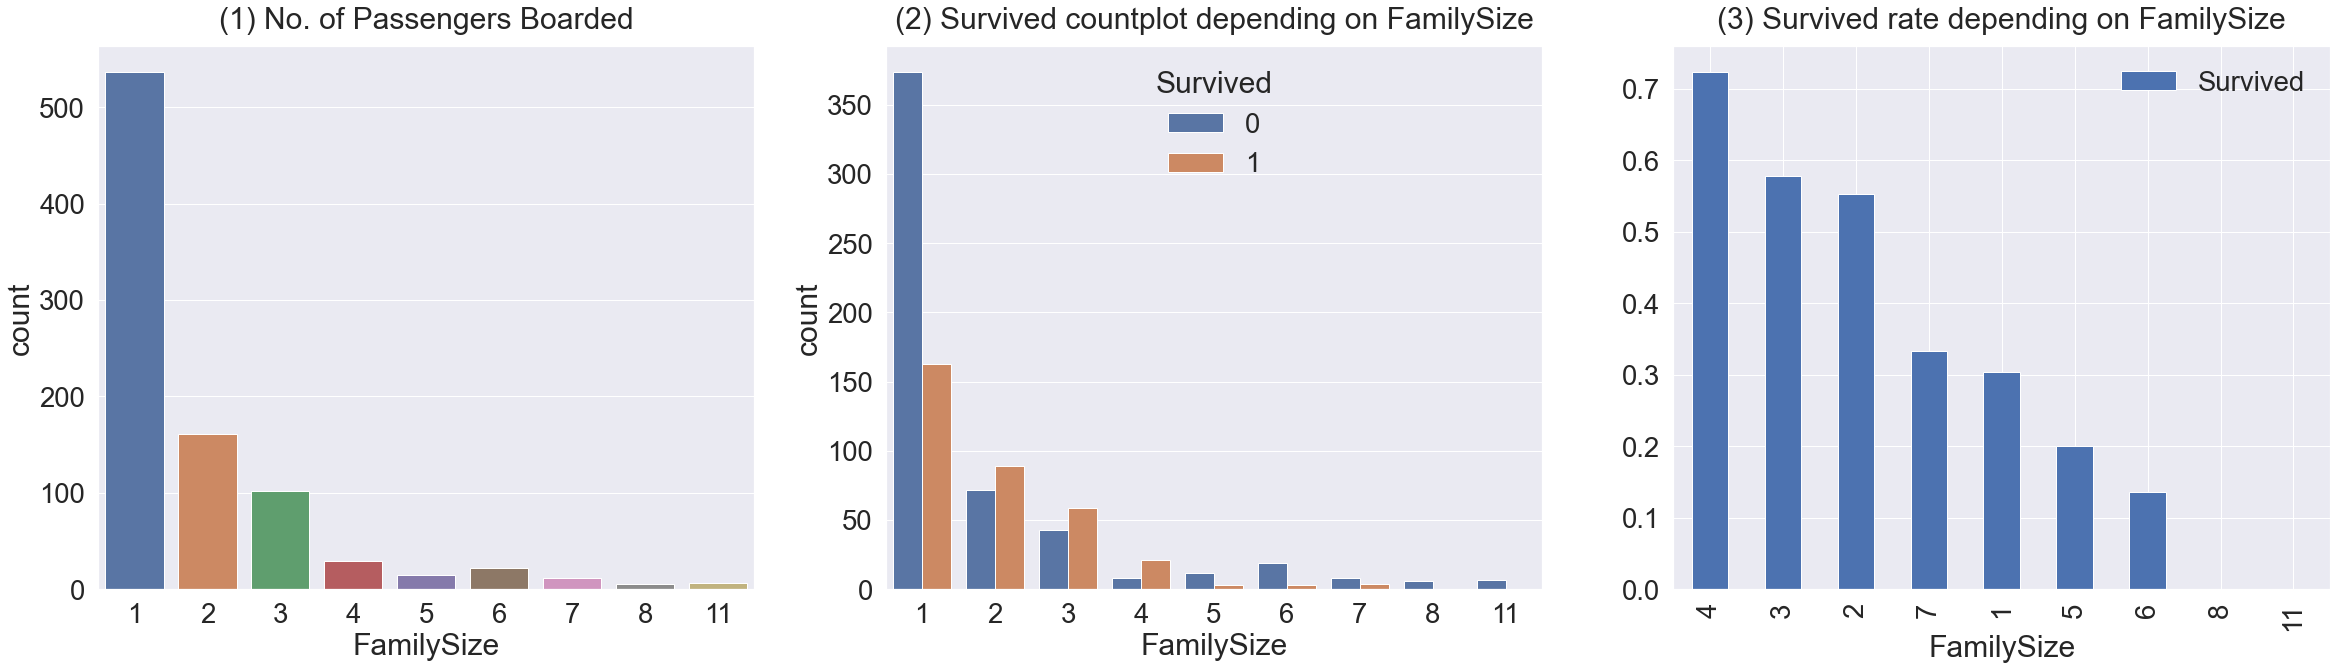

In [31]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot("FamilySize", data=df_train, ax=ax[0])
ax[0].set_title("(1) No. of Passengers Boarded", y=1.02)
sns.countplot("FamilySize", hue="Survived", data=df_train, ax=ax[1])
ax[1].set_title("(2) Survived countplot depending on FamilySize", y=1.02)

df_train[["FamilySize", "Survived"]].groupby(["FamilySize"], as_index=True).mean().sort_values(by="Survived", ascending=False).plot.bar(ax=ax[2])
ax[2].set_title("(3) Survived rate depending on FamilySize", y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure (1) - 가족 크기가 1 ~ 11까지 있음을 볼 수 있다. 대부분 1명이고 그 다음으로 2, 3, 4명이다.
- Figure (2), (3) - 가족 크기에 따른 생존 비교이다. 가족이 4명인 경우가 가장 생존 확률이 높다. 가족 수가 많아질수록 (5, 6, 7 , 8, 11) 생존 확률이 낮아진다. 가족 수가 너무 작아도(1), 너무 커도(5, 6, 8, 11) 생존 확률이 작다. 3 ~ 4명 선에선 생존 확률이 높은 걸 확인할 수 있다.

## 2.8 Fare
- `Fare`는 탑승요금이며, continous feature이다. 한 번 histogram을 그려보자

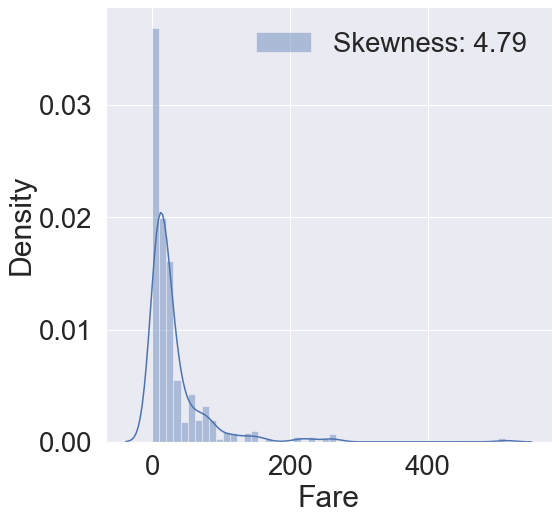

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train["Fare"], color="b", label=f"Skewness: {df_train['Fare'].skew():.2f}", ax=ax)
g = g.legend(loc="best")

- 보다시피 distribution이 매우 비대칭적인 것을 알 수 있다. (high skewness) 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있다. 몇 개 없는 outlier에 대해서 너무 민감하게 반응한다면, 실제 예측 시에 좋지 못한 결과를 부를 수 있다.
- outlier의 영향을 줄익 ㅣ위해 `Fare`에 log를 취해보자.
- 여기서 우리는 `pandas`의 유용한 기능을 사용할 것이다. `DataFrame`의 특정 `columns`에 공통된 작업(함수)을 적용하고 싶으면 아래의 map 또는 apply를 사용하면 매우 손쉽게 적용할 수 있다.
- 우리가 지금 원하는 것은 `Fare columns`의 데이터 모두를 log값 취하는 것인데, 파이썬의 간단한 `lambda`함수를 이용해 간단한 로그를 적용하는 함수를 `map`에 인수로 넣어주면 ,`Fare columns`의 데이터에 그대로 적용이 된다.

In [33]:
df_test.loc[df_test.Fare.isnull(), "Fare"] = df_test["Fare"].mean() # test set에 있는 nan value를 평균값으로 치환

df_train["Fare"] = df_train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
df_test["Fare"] = df_test["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

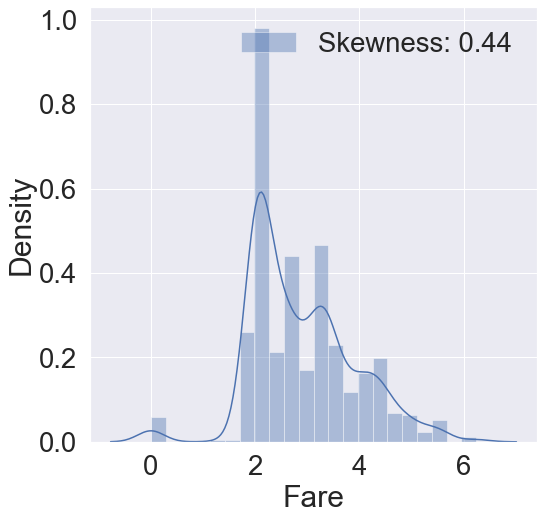

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train["Fare"], color="b", label=f"Skewness: {df_train['Fare'].skew():.2f}", ax=ax)
g = g.legend(loc="best")

- log를 취하니 이제 비대칭성이 많이 사라진 것을 확인할 수 있다.
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있다.
- 사실 방금 한 것은 `feature engineering`에 들어가는 부분인데 여기서 작업했다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 `feature`들에 여러 조작을 가하거나, 새로운 `feature`를 추가하는 것을 `feature engineering`이라고 하는데, 우리는 이제 그것을 살펴볼 것이다.

## 2.9 Cabin
- 이 `feature`는 `NaN`이 대략 80%이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지는 않다.
- 그러므로 우리가 세우려는 모델에 포함시키지 않도록 한다.

In [35]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


## 2.10 Ticket
- 이 `feature`는 `NaN`은 없다. 일단 `string data`이므로 우리가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해선 사실 아이디어가 필요하다.

In [36]:
df_train["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

- 보다시피 ticket number는 매우 다양하다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까? 

# 3. Feature Engineering
- 본격적인 feature engineering을 시작해보자
- 가장 먼저 `dataset`에 존재하는 `null data`를 채우려고 한다.
- 아무 숫자로 채울 수는 없고, `null data`를 포함하는 `feature`의 `statistics`를 참고하거나 다른 아이디어를 짜내어 채울 수 있다.
- `null data`를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써줘야한다.
- Feature Engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, `train` 뿐만 아니라 `test`도 똑같이 적용해주어야 한다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title
- `Age`에는 `null data`가 177개나 있다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 `title + statistics`를 사용해 보겠다.
- 영어에서는 `Miss`, `Mr`, `Mrs`같은 `title`이 존재한다. 각 탑승객의 이름에는 꼭 이런 `title`이 들어가게 되는데, 이를 사용해보자.
- `pandas.Series`에서는 `data`를 `string`으로 바꿔주는 `str method`, 거기에 정규표현식을 적용하게 해주는 `extract method`가 있다. 이를 사용하여 `title`을 쉽게 추출할 수 있다. `title`을 initial cloumn에 저장하자

In [37]:
df_train["Initial"] = df_train.Name.str.extract("([A-Za-z]+)\.") # lets extract the Salutations
df_test["Initial"] = df_test.Name.str.extract("([A-Za-z]+)\.") # lets extract the Salutations

- `pandas`의 `crosstab`을 이용하여 우리가 추출한 `Initial`과 `Sex` 간의 count를 살펴보자

In [38]:
pd.crosstab(df_train["Initial"], df_train["Sex"]).T.style.background_gradient(cmap="summer_r") # checking the initials with the sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [39]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [40]:
df_train.groupby("Initial").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- 여성과 관계 있는 Miss, Mrs가 생존율이 높다.

<AxesSubplot:xlabel='Initial'>

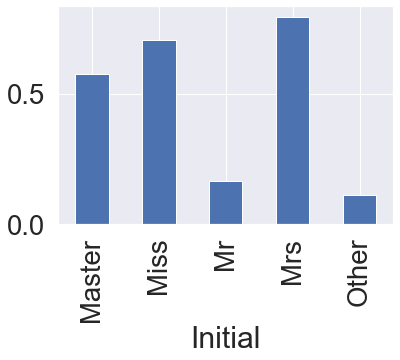

In [41]:
df_train.groupby("Initial")["Survived"].mean().plot.bar()

- 이제 본격적으로 `Null`을 채울 것이다. `null data`를 채우는 방법은 정말 많이 존재한다. `statistics`를 활용하는 방법도 있고, `null data`가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워 넣는 방식도 있다. 여기서는 `statistics`를 활용하는 방법을 사용 할 것이다.
- 여기서 `statistics`는 `train data`의 것을 의미한다. 우리는 언제나 `test`를 __unseen__ 으로 둔 상태로 놔둬야 하며, `train`에서 얻은 `statistics`를 기반으로 `test`의 `null data`를 채워줘야 한다.

In [42]:
df_train.groupby("Initial").mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- `Age`의 평균을 이용해 `Null value`를 채우도록 하자
- `pandas.DataFrame`을 다룰 때에는 `boolean array`를 이용해 indexing하는 방법이 편하다.
- 아래 코드 첫 줄을 해석하자면, `isnull()`이면서 `Initial`이 `Mr`인 조건을 만족하는 row(탑승객)의 `Age`의 값을 33으로 치환한다. 이다.
- `loc` + `boolean` + `column`을 사용해 값을 치환하는 방법은 자주 쓰인다.

In [43]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

Null을 채우는 다양한 방법 [참고링크](https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook)

### 3.1.2 Fill Null in Embarked

In [44]:
print("Embarked has", sum(df_train["Embarked"].isnull()), "Null values")

Embarked has 2 Null values


- `Embarked`는 `Null`값이 2개이고 ,`S`에서 가장 많은 탑승객이 있었으므로 간단하게 `Null`을 `S`로 채우자.
- dataframe의 `fillna` 메소드를 이용하면 쉽게 채울 수 있다. 여기서 `inplace=True`로 하면 `df_train`에 `fillna`를 실제로 적용하게 된다.

In [45]:
df_train["Embarked"].fillna("S", inplace=True)

## 3.2 Change Age (continuous to categorical)
- `Age`는 현재 continuous feature이다. 이대로 써도 모델을 세울 수 있지만, `Age`를 몇 개의 그룹으로 나누어 category화 시켜줄 수도 있다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있으니 주의해야한다.
- 방법에는 여러가지가 있다. 데이터프레임의 indexing 방법인 `loc`를 사용해서 직접 해줄 수 있고, 아니면 `apply`를 사용해 함수를 넣어줄 수 있다.
- 첫 번째로 `loc`를 사용한 방법이다.
- 나이는 10살 간격으로 나누자

In [46]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

- 두 번째로 간단한 함수를 만들어 `apply` 메소드에 넣어주는 방법이며, 훨씬 수월하다

In [47]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train["Age_cat_2"] = df_train["Age"].apply(category_age)

- 두 가지 방법이 잘 적용됐다면, 둘 다 같은 결과를 내야 한다.
- 이를 확인하기 위해 `Series` 간 boolean 비교 후 `all()` 메소드를 사용하자. `all()` 메소드는 모든 값이 `True`면 `True`, 하나라도 `False`가 있으면 `False`를 준다. 

In [48]:
print("1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야 함 ->", (df_train["Age_cat"] == df_train["Age_cat_2"]).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야 함 -> True


- 보다시피 `True`이다.
- 이제 중복되는 `Age_cat` column과 원래 column인 `Age`를 제거하자

In [49]:
df_train.drop(["Age", "Age_cat_2"], axis=1, inplace=True)
df_test.drop(["Age"], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)
- 현재 `Initial`은 `Mr`, `Mrs`, `Miss`, `Mister`, `Other` 총 5개로 이루어져 있다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 input으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화시키는 것이다.
- `map` 메소드를 갖고 간단히 할 수 있다.
- 사전 순서대로 정리하여 mapping하자

In [50]:
df_train["Initial"] = df_train["Initial"].map({"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Other": 4})
df_test["Initial"] = df_test["Initial"].map({"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Other": 4})

- `Embarked`도 `C`, `Q`, `S`로 이루어져 있다. `map`을 이용하여 바꿔보자.
- 그 전에 특정 column에 어떤 값들이 있는지 확인해보는 방법을 잠깐 살펴보자. 간단히 `unique()` 메소드를 쓰거나 `value_counts()`를 써서 count까지 보는 방법이 있다.

In [51]:
df_train["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [52]:
df_train["Embarked"].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

- 위 두 방법을 이용해 `Embarked`가 `S`, `C`, `Q` 세 가지로 이루어진 것을 볼 수 있다.
- 이제 `map`을 사용해보자.

In [53]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

- 한 번 `Null`이 사라졌는지 확인해보자. 
- `Embarked` column만 가져온 것은 하나의 `pandas.Series` 객체이므로 `isnull()` 메소드를 사용해 Series의 값들이 `null`인지 아닌지에 대한 boolean 값을 얻을 수 있다. 
- 그리고 이것을 `any()`를 사용하여 `True`가 단 하나라도 있을 시(`Null`이 한 개라도 있을 시) `True`를 반환해주게 된다. 우리는 `Null`을 `S`로 다 바꿔주었으므로 `False`를 얻어야 한다.

In [54]:
df_train["Embarked"].isnull().any()

False

- `Sex`도 `female`과 `male`로 이루어져 있다. `map`을 이용해 바꿔보자

In [55]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

- 이제 각 feature 간 상관관계를 보자. 두 변수 간의 `Pearson correlation`을 구하면 `(-1, 1)` 사이의 값을 얻을 수 있다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미한다. <br>
$$r_{xy} = \frac{Cov(x, y)}{S_xS_y} = \frac{\frac{1}{n-1}\sum^n_{i=1}(x_i - \bar{x})(y_i - \bar{y})}{S_xS_y}$$
- 우리는 여러 feature를 가지고 있으니 이를 하나의 matrix 형태로 보면 편할텐데, 이를 `heatmap plot`이라고 하며, `dataframe`의 `corr()` 메소드와 `seaborn`을 가지고 편하게 그릴 수 있다.

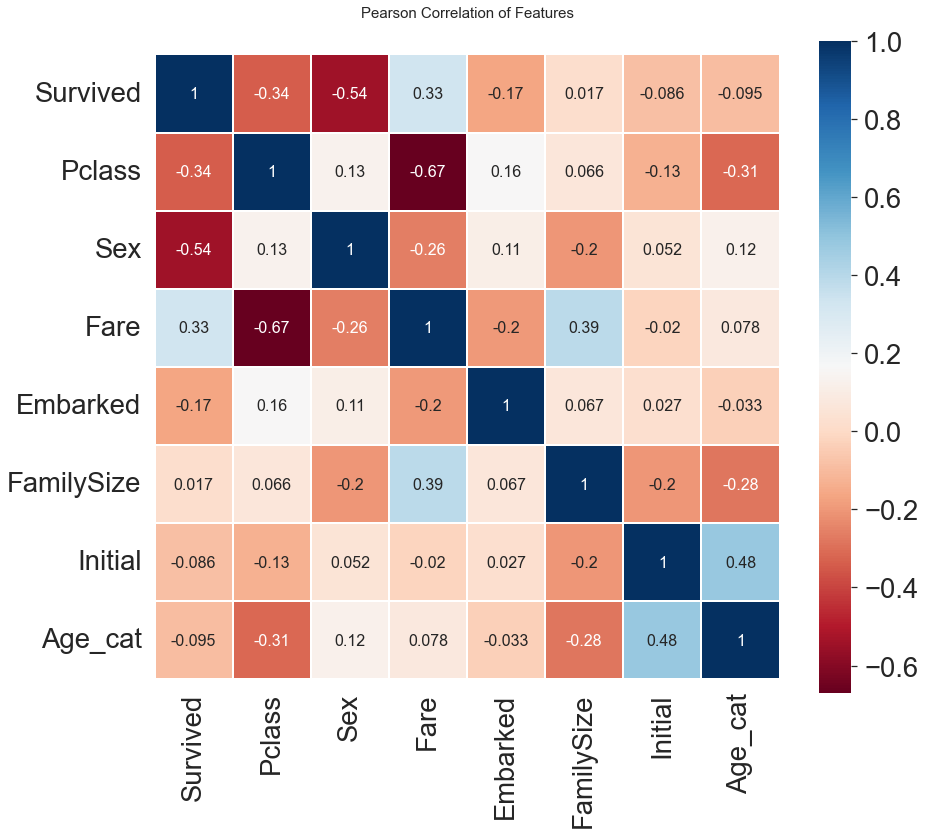

In [56]:
heatmap_data = df_train[["Survived", "Pclass", "Sex", "Fare", "Embarked", "FamilySize", "Initial", "Age_cat"]]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor="white", annot=True, annot_kws={"size": 16})

del heatmap_data

- 우리가 EDA에서 살펴봤듯이 `Sex`와 `Pclass`가 `Survived`에 상관관계가 어느 정도 있음을 볼 수 있다.
- 생각보다 `fare`와 `Embarked`와도 상관관계가 있는 것을 볼 수 있다.
- 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것이다.
- 이것은 우리가 모델을 학습시킬 때 불필요한(redundant, superfluous) feature가 없다는 것을 의미한다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나이기 때문이다.
- 이제 실제로 모델을 학습시키기에 앞서 data preprocessing(전처리)를 진행해보자.

## 3.4 One-hot encoding on Initial and Embarked
- 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있다.
- 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말한다.
- One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말한다.
||Initial_Master|Initial_Miss|Initial_Mr|Initial_Mrs|Initial_Other|
|---|---|---|---|---|---|
|Master|1|0|0|0|0|
|Miss|0|1|0|0|0|
|Mr|0|0|1|0|0|
|Mrs|0|0|0|1|0|
|Other|0|0|0|0|1|
- 위와 같은 작업을 직접 코딩할 수도 있지만, `pandas`의 `get_dummies`를 사용하여 쉽게 해결할 수 있다.
- 총 5개의 카테고리이니 one-hot encoding을 하고 나면 새로운 5개의 column이 생겨난다.
- `Initial`을 prefix로 두어서 구분이 쉽게 만들어준다.

In [57]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [58]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


- 보다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns가 생성된 것이 보인다.
- `Embarked`에도 적용해보자. `Initial` 때와 마찬가지로 one-hot encoding을 사용해 표현해보겠다.

In [59]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

- 아주 쉽게 one-hot encoding을 적용했다.
- `sklearn`의 `LabelEncoder` + `OneHotEncoder`를 이용해도 one-hot encoding이 가능하다.
- 가끔 category가 100개가 넘어가는 경우가 있는데, 이 때 one-hot encoding을 사용하면 column이 100개가 생겨 학습 시 매우 버거울 수 있다. 이런 경우는 다른 방법을 사용하기도 하는데 일단은 넘어가자.

# 3.5 Drop columns
- 필요한 column만 남기고 다 지우자

In [60]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [61]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [62]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


- 보다시피 `train`의 `Survived`(target class) 빼고 `train`, `test` 둘 다 같은 columns를 가진 것을 확인할 수 있다.

# 4. Building machine learning model and prediction using the trained model
- `sklearn`을 사용해 본격적으로 머신러닝 모델을 만들어보자

In [63]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier
from sklearn import metrics # 모델의 평가를 위해 사용
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수

- `sklearn`은 머신러닝의 처음부터 끝까지 다 있다. feature engineering, preprocessing, 지도학습 알고리즘, 비지도학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있다.
- 타이타닉 문제는 target class (`Survived`)가 있으며, target class는 `0`과 `1`로 이루어져 있으므로 binary classification 문제이다.
- 우리가 지금 가지고 있는 train set과 Survived를 제외한 input을 가지고 모델을 최적화시켜 각 샘플(탑승객)의 생존 유무를 판별하는 모델을 만들어 낸다.
- 그 후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플의 생존 여부를 예측해본다.

## 4.1 Preparation - Split dataset into train, valid, test set
- 가장 먼저 학습에 쓰일 데이터와 target label을 분리한다. `drop`을 사용해 간단히 할 수 있다.

In [64]:
X_train = df_train.drop("Survived", axis=1).values
target_label = df_train["Survived"].values
X_test = df_test.values

- 보통은 `train`, `test`만 언급되지만, 실제 좋은 모델을 만들기 위해 `valid set`을 따로 만들어 모델 평가를 해본다.
- `train_test_split`을 사용하여 쉽게 train set을 분리할 수 있다.

In [65]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

- 본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하자.
- 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델이다.
- 각 머신러닝 알고리즘에는 여러 파라미터들이 있다. 랜덤포레스트분류기도 `n_estimators`, `max_features`, `max_depth`, `min_samples_split`, `min_samples_leaf` 등 여러 파라미터들이 존재한다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라진다.
- 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요하다. 결국 많이 써봐야 모델도 잘 세울 수 있는 것이다.
- 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행한다..
- 모델 객체를 만들고, fit 메소드로 학습시킨다.
- 그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻는다.

## 4.2 Model generation and prediction

In [66]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

- 단 세 줄만으로 모델을 세우고 예측까지 했다.
- 이제 모델 성능을 살펴보자

In [67]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.84% 정확도로 생존을 맞춤


- 아무런 파라미터 튜닝도 하지 않았는데 82%의 정확도가 나왔다.

##  4.3 Feature Importance
- 학습된 모델은 `feature importance` 를 가지게 되는데, 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있다.
- 쉽게 말해, 10 = 4x1 + 2x2 + x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있다.
- 학습된 모델은 기본적으로 `feature importances` 를 가지고 있어서 쉽게 그 수치를 얻을 수 있다.
- `pandas.Series` 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있다.

In [68]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

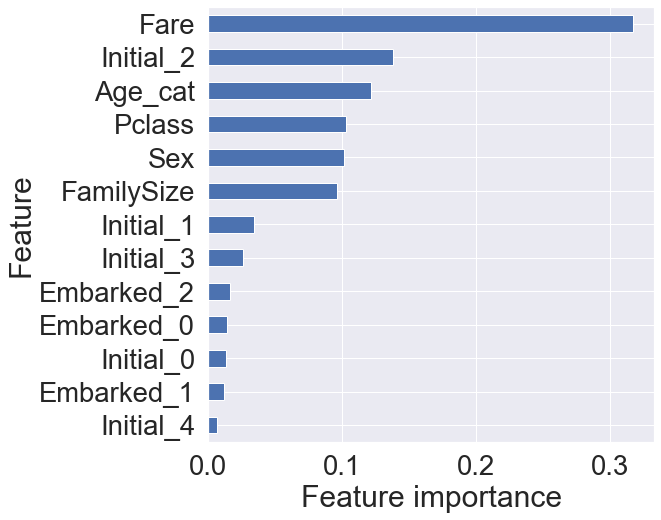

In [69]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

- 우리가 얻은 모델에서는 `Fare` 가 가장 큰 영향력을 가지며, 그 뒤로 `Initial_2`, `Age_cat`, `Pclass`가 차례로 중요도를 가진다
- 사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있다.
- 이 feature importance 를 보고 실제로 `Fare` 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야한다.
- feature importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있다.

## 4.4 Prediction on Test set
- 이제 모델이 학습하지 않았던 (보지 안았던) 테스트셋을 모델에 주어서 생존 여부를 예측해보자.
- 이 결과는 실제로 submission용이므로 결과를 leaderboard에서 확인할 수 있다.
- 캐글에서 준 파일, `gender_submission.csv` 파일을 읽어서 제출 준비를 하자.

In [71]:
submission = pd.read_csv('./data/gender_submission.csv')

In [72]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [73]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [74]:
submission.to_csv('./my_first_submission.csv', index=False)

- 해당 파일을 캐글에 제출하면 된다.